# 2023 Immune dataset H3K4me3 noise - added control

Data:
https://www.encodeproject.org/immune-cells/?type=Experiment&replicates.library.biosample.donor.organism.scientific_name=Homo+sapiens&biosample_ontology.cell_slims=hematopoietic+cell&biosample_ontology.classification=primary+cell&control_type!=*&status!=replaced&status!=revoked&status!=archived&biosample_ontology.system_slims=immune+system&biosample_ontology.system_slims=circulatory+system&config=immune

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file

def d(a, b):
    return a / b if b != 0 else 0

def sorted_file(file):
    ts = tempfile.mktemp()
    !cat {file} | sort -k1,1 -k2,2n > {ts}
    return ts

def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file

## Load peaks

In [3]:
PATH = os.path.expanduser('~/data/2023_Immune_noise')
IMMUNE_CELLS = ['BCell', 'TCell', 'Monocyte']
MODIFICATIONS = ['H3K4me3']

! mkdir -p {PATH}/pics

In [4]:
def load_peaks_fdr(path, suffix, fdrs):
    df_fdr = pd.DataFrame(columns=['file', 'modification', 'cell', 'fdr', 'peaks', 'avlength'],
                          dtype=object)
    for f in tqdm(os.listdir(path)):
        if suffix not in f:
            continue
        fdr = next((fdr for fdr in fdrs if fdr in f), None)
        cell = next((cc for cc in IMMUNE_CELLS if cc in f), None)
        mod = next((m for m in MODIFICATIONS if m in f), None)
        # print(f, fdr, cell, mod)
        if fdr and cell and mod:
            peaks_path = os.path.join(path, f)
            ps, ls = lines(peaks_path), bedl(peaks_path)
            avls = 0 if ps == 0 else sum(ls) / ps
            df_fdr.loc[len(df_fdr)] = (peaks_path, mod, cell, fdr, ps, avls)
    return df_fdr


In [5]:
def load_peaks(path):
    df_fdr_macs2 = load_peaks_fdr(os.path.join(path, 'macs2'), '.narrowPeak', ['0.05'])
    df_fdr_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_fdr_macs2))

    df_fdr_macs2broad = load_peaks_fdr(os.path.join(path, 'macs2'), '.broadPeak', ['0.1'])
    df_fdr_macs2broad['tool'] = 'MACS2 broad'
    print('MACS2 broad', len(df_fdr_macs2broad))

    df_fdr_sicer = load_peaks_fdr(os.path.join(path, 'sicer'), 'summary-FDR', ['0.01'])
    df_fdr_sicer['tool'] = 'SICER'
    print('SICER', len(df_fdr_sicer))

    df_fdr_span = load_peaks_fdr(os.path.join(path, 'span'), '.peak', ['0.05'])
    df_fdr_span['tool'] = 'SPAN'
    print('SPAN', len(df_fdr_span))

    return pd.concat([df_fdr_macs2, df_fdr_macs2broad, df_fdr_sicer, df_fdr_span]).reset_index(drop=True)

In [6]:
df_fdr_peaks_noise = load_peaks(PATH)
df_fdr_peaks_noise['quality'] = 0
for mln in [15, 10, 5, 2, 1]:
    df_fdr_peaks_noise.loc[[f'_{mln}mln' in file for file in df_fdr_peaks_noise['file']], 'quality'] = mln
df_fdr_original_peaks = load_peaks(os.path.expanduser('~/data/2023_Immune'))
df_fdr_original_peaks['quality'] = 20
df_fdr_peaks = pd.concat([df_fdr_peaks_noise, df_fdr_original_peaks]).reset_index(drop=True)

  0%|          | 0/560 [00:00<?, ?it/s]

MACS2 15


  0%|          | 0/560 [00:00<?, ?it/s]

MACS2 broad 15


  0%|          | 0/71 [00:00<?, ?it/s]

SICER 16


  0%|          | 0/73 [00:00<?, ?it/s]

SPAN 15


  0%|          | 0/112 [00:00<?, ?it/s]

MACS2 3


  0%|          | 0/112 [00:00<?, ?it/s]

MACS2 broad 3


  0%|          | 0/118 [00:00<?, ?it/s]

SICER 3


  0%|          | 0/17 [00:00<?, ?it/s]

SPAN 3


In [7]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

## Peaks number and lengths

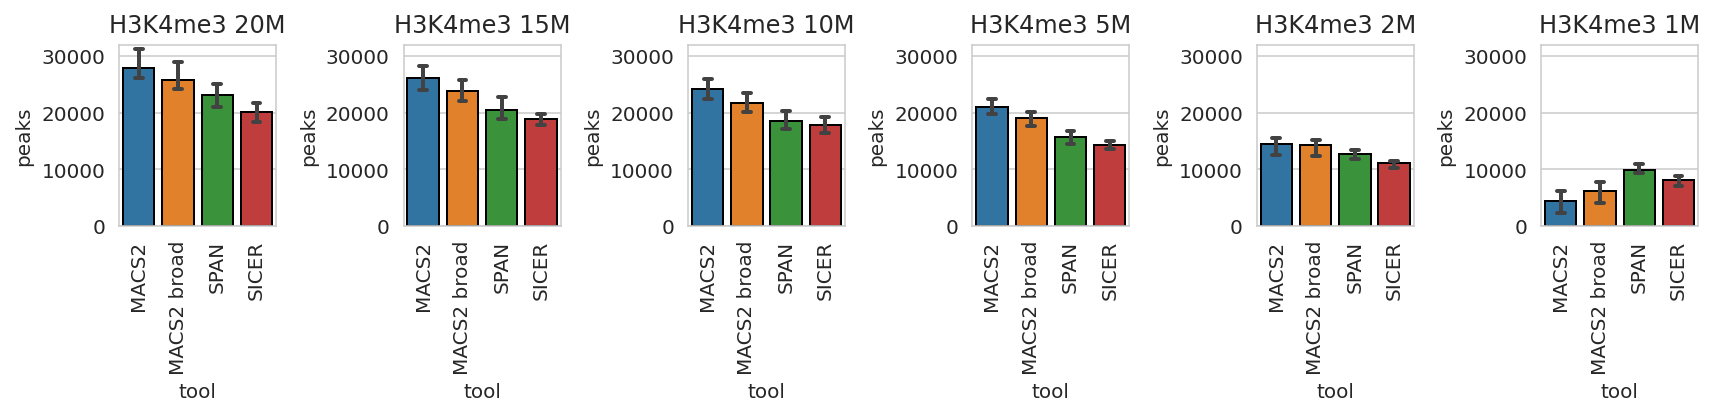

In [8]:
plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]

for i, mln in enumerate([20, 15, 10, 5, 2, 1]):
    ax = axs[i]
    g_results = sns.barplot(data=df_fdr_peaks[df_fdr_peaks['quality']==mln],
                            x='tool', y='peaks', ax=ax,
                            capsize=.2, errwidth=2, edgecolor="black",
                            palette=TOOLS_PALETTE,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
    ax.set_ylim(0, 32_000)
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(f'H3K4me3 {mln}M')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K4me3_peaks.pdf', bbox_inches='tight', dpi=300)
plt.show()

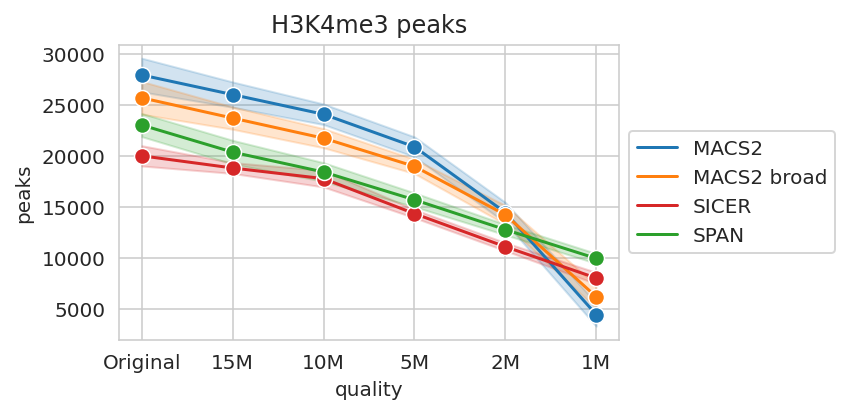

In [9]:
df_fdr_peaks['q'] = 0
for i, mln in enumerate([20, 15, 10, 5, 2, 1]):
    df_fdr_peaks.loc[df_fdr_peaks['quality'] == mln, 'q'] = i

plt.figure(figsize=(6, 3))
g_results = sns.lineplot(data=df_fdr_peaks,
                         x='q', y='peaks', hue='tool',
                         hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                         palette=TOOLS_PALETTE,
                         errorbar='se', marker='o', markersize=8)
g_results.axes.set_xticks(range(6), minor=False)
g_results.axes.set_xticklabels(['Original', '15M', '10M', '5M', '2M', '1M'])
g_results.axes.set_xlabel('quality')
g_results.axes.title.set_text(f'H3K4me3 peaks')
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K4me3_peaks2.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [10]:
ts = []
for mln, file, tool in tqdm(zip(df_fdr_peaks['quality'], df_fdr_peaks['file'], df_fdr_peaks['tool'])):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 10_000))
    t['quality'] = mln
    t['name'] = tool
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

0it [00:00, ?it/s]

,length,quality,name
482001,397,5,SPAN
13497,397,2,MACS2
426579,1459,2,SPAN
38484,714,10,MACS2
444165,960,10,SPAN
669962,92,20,SPAN
181708,373,1,MACS2 broad
503963,697,2,SPAN
254310,982,5,MACS2 broad
218417,459,15,MACS2 broad


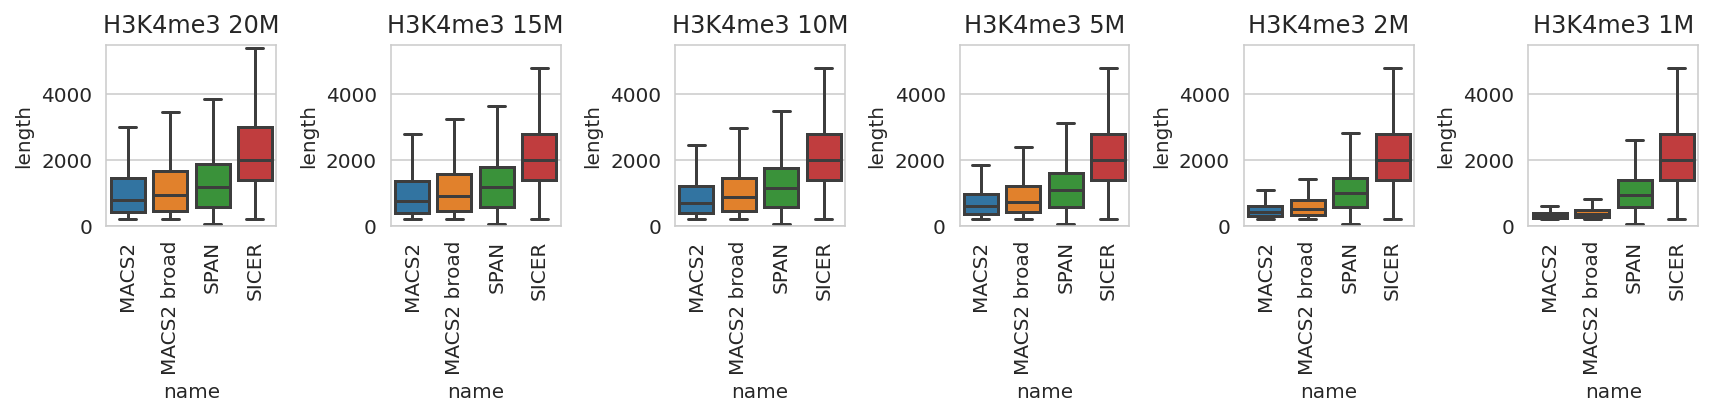

In [11]:
plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]
for i, mln in enumerate([20, 15, 10, 5, 2, 1]):
    ax = axs[i]
    g_results = sns.boxplot(data=t[t['quality']==mln], x='name', y='length', ax=ax,
                            palette=TOOLS_PALETTE,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            showfliers=False)
    ax.title.set_text(f'H3K4me3 {mln}M')
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylim([-10, 5500])
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K4me3_lengths.pdf', bbox_inches='tight', dpi=300)
plt.show()

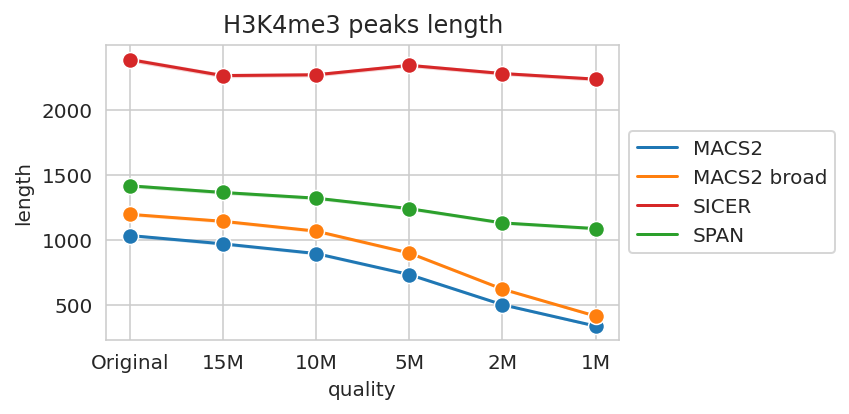

In [12]:
t['q'] = 0
for i, mln in enumerate([20, 15, 10, 5, 2, 1]):
    t.loc[t['quality'] == mln, 'q'] = i

plt.figure(figsize=(6, 3))
g_results = sns.lineplot(data=t,
                         x='q', y='length', hue='name',
                         hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                         palette=TOOLS_PALETTE,
                         errorbar='se', marker='o', markersize=8)
g_results.axes.set_xticks(range(6), minor=False)
g_results.axes.set_xticklabels(['Original', '15M', '10M', '5M', '2M', '1M'])
g_results.axes.set_xlabel('quality')
g_results.axes.title.set_text(f'H3K4me3 peaks length')
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K4me3_lengths2.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Footprint

In [13]:
ts = []
for mln, file, tool in tqdm(zip(df_fdr_peaks['quality'], df_fdr_peaks['file'], df_fdr_peaks['tool'])):
    coverage = bedl(file).sum()
    ts.append((mln, tool, coverage))
t = pd.DataFrame(data=ts, columns=['quality', 'name', 'coverage'])
del ts
t.sample(1)

0it [00:00, ?it/s]

,quality,name,coverage
40,5,SICER,33610251


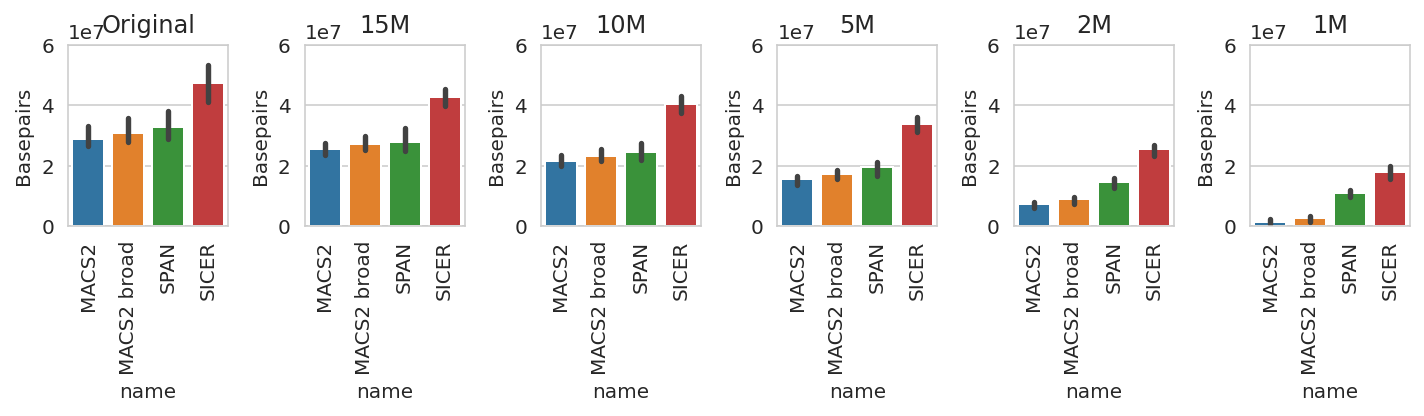

In [14]:
plt.figure(figsize=(10, 3))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]
for i, mln in enumerate([20, 15, 10, 5, 2, 1]):
    ax = axs[i]
    g_results = sns.barplot(data=t[t['quality']==mln], x='name', y='coverage', ax=ax,
                            palette=TOOLS_PALETTE,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
    ax.title.set_text(f'{mln}M' if mln != 20 else 'Original')
    ax.set_ylabel('Basepairs')
    ax.set_ylim([0, 0.6e8])
    ax.xaxis.set_tick_params(rotation=90)
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K4me3_sumlength.pdf', bbox_inches='tight', dpi=300)
plt.show()

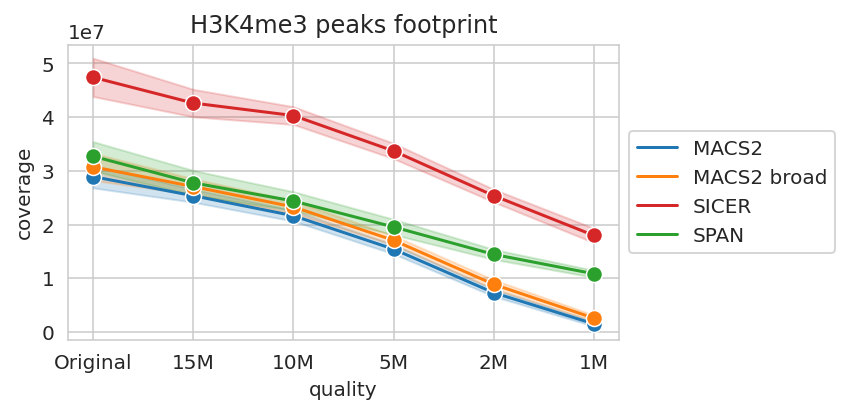

In [15]:
t['q'] = 0
for i, mln in enumerate([20, 15, 10, 5, 2, 1]):
    t.loc[t['quality'] == mln, 'q'] = i

plt.figure(figsize=(6, 3))
g_results = sns.lineplot(data=t,
                         x='q', y='coverage', hue='name',
                         hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                         palette=TOOLS_PALETTE,
                         errorbar='se', marker='o', markersize=8)
g_results.axes.set_xticks(range(6), minor=False)
g_results.axes.set_xticklabels(['Original', '15M', '10M', '5M', '2M', '1M'])
g_results.axes.set_xlabel('quality')
g_results.axes.title.set_text(f'H3K4me3 peaks footprint')
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K4me3_sumlength2.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Jaccard vs original peaks

In [16]:
import tempfile
from itertools import product

mln_bench_df = pd.DataFrame(
    columns=['cell', 'name', 'full_peaks', 'full_peaks_len',
             'quality', 'mln_peaks', 'mln_peaks_len',
             'full_overlap', 'mln_overlap',
             'overlap_len'],
    dtype=object
)

tf = tempfile.mktemp()

for c, tool in tqdm(product(IMMUNE_CELLS, TOOLS)):
    print(c, tool)
    t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                     (df_fdr_peaks['modification'] == 'H3K4me3') &
                     (df_fdr_peaks['cell'] == c) &
                     (df_fdr_peaks['quality'] == 20)]
    if len(t) == 0:
        continue
    full_file = sorted_file(t['file'].values[0])
    full_peaks = lines(full_file)
    full_peaks_len = int(bedl(full_file).sum())
    for mln in [15, 10, 5, 2, 1]:
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['quality'] == mln)]
        if len(t) == 0:
            continue
        mln_file = sorted_file(t['file'].values[0])
        mln_peaks = lines(mln_file)
        mln_peaks_len = int(bedl(mln_file).sum())
        !bedtools intersect -a {full_file} -b {mln_file} -wa -u > {tf}
        full_peaks_overlap = lines(tf)
        !bedtools intersect -b {full_file} -a {mln_file} -wa -u > {tf}
        mln_peaks_overlap = lines(tf)
        !bedtools intersect -a {full_file} -b {mln_file} -wo > {tf}
        overlap_len = int(last_col(tf).sum())
        mln_bench_df.loc[len(mln_bench_df)] = \
            (c, tool,
             full_peaks, full_peaks_len,
             mln, mln_peaks, mln_peaks_len,
             full_peaks_overlap, mln_peaks_overlap,
             overlap_len)

display(mln_bench_df.sample())

0it [00:00, ?it/s]

BCell MACS2
BCell MACS2 broad
BCell SPAN
BCell SICER
TCell MACS2
TCell MACS2 broad
TCell SPAN
TCell SICER
Monocyte MACS2
Monocyte MACS2 broad
Monocyte SPAN
Monocyte SICER


,cell,name,full_peaks,full_peaks_len,quality,mln_peaks,mln_peaks_len,full_overlap,mln_overlap,overlap_len
15,BCell,SICER,18342,48082858,15,17894,40583306,17434,17647,38478737


In [17]:
mln_bench_df['precision'] = [d(a, b) for a, b in zip(mln_bench_df['mln_overlap'], mln_bench_df['mln_peaks'])]
mln_bench_df['sensitivity'] = [d(a, b) for a, b in zip(mln_bench_df['full_overlap'], mln_bench_df['full_peaks'])]
mln_bench_df['f1'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                      for s, p in zip(mln_bench_df['sensitivity'], mln_bench_df['precision'])]

mln_bench_df['precision_len'] = [d(a, b) for a, b in zip(mln_bench_df['overlap_len'], mln_bench_df['mln_peaks_len'])]
mln_bench_df['sensitivity_len'] = [d(a, b) for a, b in zip(mln_bench_df['overlap_len'], mln_bench_df['full_peaks_len'])]
mln_bench_df['f1_len'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                          for s, p in zip(mln_bench_df['sensitivity_len'], mln_bench_df['precision_len'])]

mln_bench_df['jaccard'] = [
    d(o, p + g -o)
    for p, g, o in zip(mln_bench_df['full_peaks_len'], mln_bench_df['mln_peaks_len'], mln_bench_df['overlap_len'])
]
mln_bench_df.sample(1)

,cell,name,full_peaks,full_peaks_len,quality,mln_peaks,mln_peaks_len,full_overlap,mln_overlap,overlap_len,precision,sensitivity,f1,precision_len,sensitivity_len,f1_len,jaccard
6,BCell,MACS2 broad,24118,28781483,10,20188,21446040,17953,20174,21409358,0.999307,0.744382,0.853209,0.99829,0.743859,0.852495,0.742912


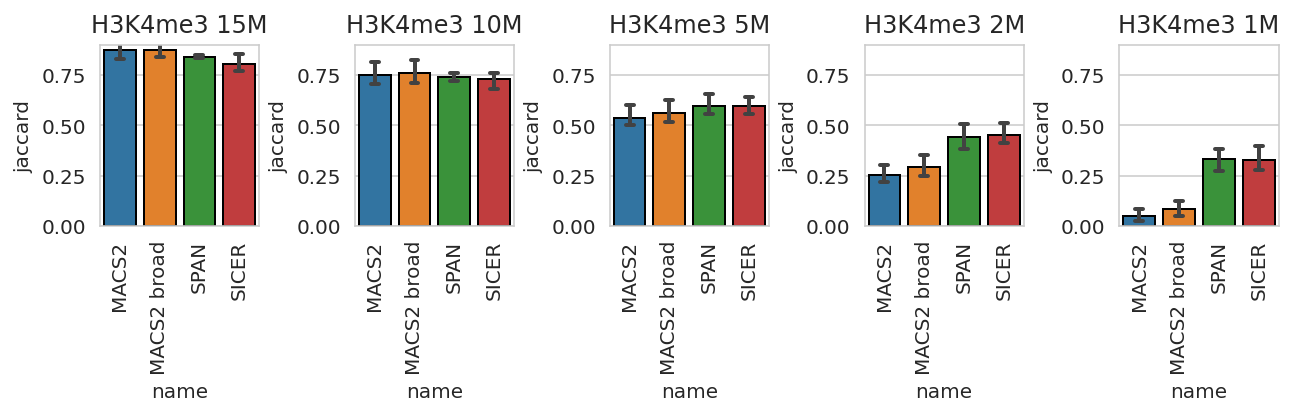

In [18]:
plt.figure(figsize=(9, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, mln in enumerate([15, 10, 5, 2, 1]):
    ax = axs[i]
    g_results = sns.barplot(data=mln_bench_df[mln_bench_df['quality']==mln],
                            x='name', y='jaccard', ax=ax,
                            capsize=.2, errwidth=2, edgecolor="black",
                            palette=TOOLS_PALETTE,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
    ax.title.set_text(f'H3K4me3 {mln}M')
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylim([0, 0.9])
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K4me3_jaccard.pdf', bbox_inches='tight', dpi=300)
plt.show()

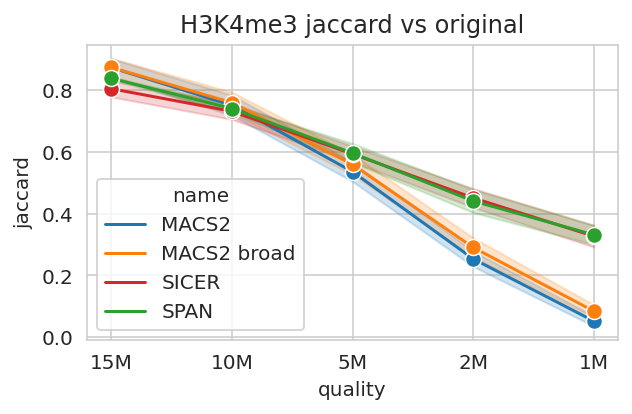

In [19]:
mln_bench_df['q'] = 0
for i, mln in enumerate([15, 10, 5, 2, 1]):
    mln_bench_df.loc[mln_bench_df['quality'] == mln, 'q'] = i

plt.figure(figsize=(4.5, 3))
g_results = sns.lineplot(data=mln_bench_df,
                         x='q', y='jaccard', hue='name',
                         hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                         palette=TOOLS_PALETTE,
                         errorbar='se', marker='o', markersize=8)
g_results.axes.set_xticks(range(5), minor=False)
g_results.axes.set_xticklabels(['15M', '10M', '5M', '2M', '1M'])
g_results.axes.set_xlabel('quality')
g_results.axes.title.set_text(f'H3K4me3 jaccard vs original')
# g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K4me3_jaccard2.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [20]:
mln_bench_df['modification'] = 'H3K4me3'
mln_bench_df.to_csv(PATH + '/H3K4me3_mln_bench_df.csv', index=False)

## Average precision
AP summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight:

AP = ∑(Rn−Rn−1)*Pn, where  Pn and Rn are the precision and recall at the nth threshold.

This implementation is not interpolated and is different from computing the area under the precision-recall curve with the trapezoidal rule, which uses linear interpolation and can be too optimistic.

0it [00:00, ?it/s]

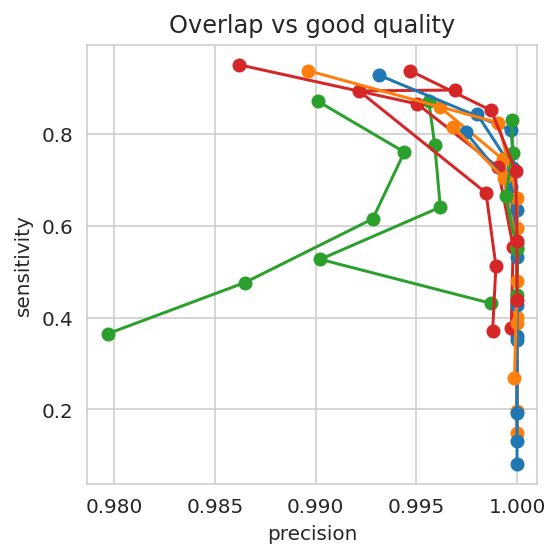

In [21]:
plt.figure(figsize=(4, 4))
for c, tool in tqdm(product(mln_bench_df['cell'].unique(), mln_bench_df['name'].unique())):
    # print(c, tool)
    dft = mln_bench_df[(mln_bench_df['cell'] == c) & (mln_bench_df['name'] == tool)].copy()
    dft = dft[dft['sensitivity'] + dft['precision'] > 0]
    dft.sort_values(by=['sensitivity', 'quality'], inplace=True)
    plt.plot(dft['precision'], dft['sensitivity'], marker='o', label=tool, color=TOOLS_PALETTE[tool])
plt.title('Overlap vs good quality')
plt.xlabel('precision')
plt.ylabel('sensitivity')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K4me3_auc.pdf', bbox_inches='tight', dpi=300)
plt.show()

0it [00:00, ?it/s]

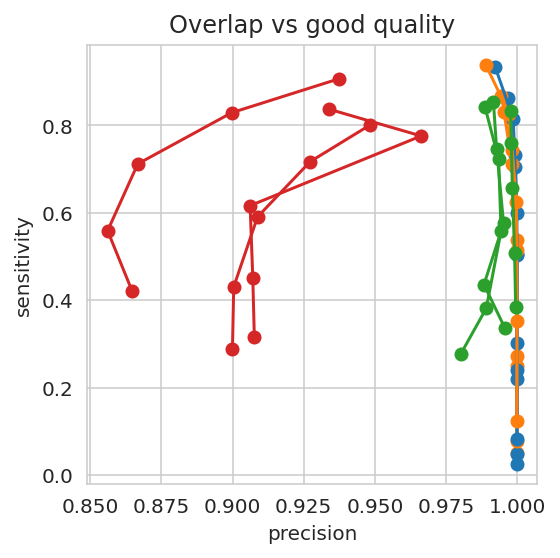

In [22]:
plt.figure(figsize=(4, 4))
for c, tool in tqdm(product(mln_bench_df['cell'].unique(), mln_bench_df['name'].unique())):
    # print(c, tool)
    dft = mln_bench_df[(mln_bench_df['cell'] == c) & (mln_bench_df['name'] == tool)].copy()
    dft = dft[dft['sensitivity_len'] + dft['precision_len'] > 0]
    dft.sort_values(by=['sensitivity_len', 'quality'], inplace=True)
    plt.plot(dft['precision_len'], dft['sensitivity_len'], marker='o', label=tool, color=TOOLS_PALETTE[tool])
plt.title('Overlap vs good quality')
plt.xlabel('precision')
plt.ylabel('sensitivity')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K4me3_auc_len.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [23]:
t = []
for c, tool in tqdm(product(mln_bench_df['cell'].unique(), mln_bench_df['name'].unique())):
    # print(c, tool)
    dft = mln_bench_df[(mln_bench_df['cell'] == c) & (mln_bench_df['name'] == tool)].copy()
    dft = dft[dft['sensitivity'] + dft['precision'] > 0]
    dft.sort_values(by=['sensitivity', 'quality'], inplace=True)
    ap = 0
    rprev = 0
    for _, row in dft.iterrows():
        ap += (row['sensitivity'] - rprev) * row['precision']
        rprev = row['sensitivity']
    t.append((c, tool, ap))
dfap = pd.DataFrame(data=t, columns=['cell', 'tool', 'AP'])
dfap

0it [00:00, ?it/s]

,cell,tool,AP
0,BCell,MACS2,0.843850
1,BCell,MACS2 broad,0.857453
2,BCell,SPAN,0.869364
3,BCell,SICER,0.948329
4,TCell,MACS2,0.803118
5,TCell,MACS2 broad,0.815404
6,TCell,SPAN,0.858815
7,TCell,SICER,0.892843
8,Monocyte,MACS2,0.927084
9,Monocyte,MACS2 broad,0.936140


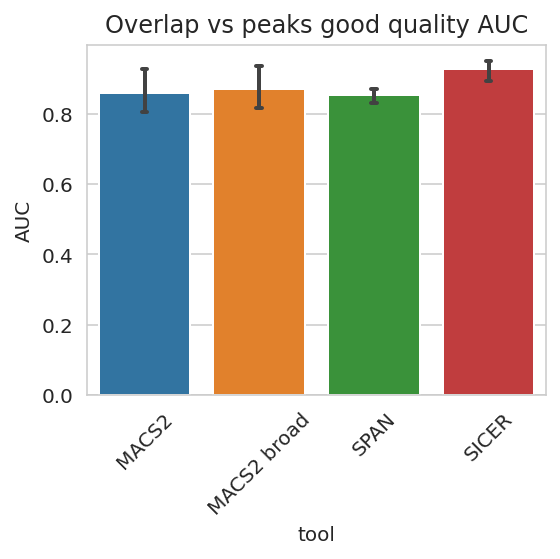

In [24]:
fig = plt.figure(figsize=(4, 4))
g_result = sns.barplot(data=dfap, x="tool", y="AP", capsize=.05, errwidth=2)
g_result.axes.xaxis.set_tick_params(rotation=45)
# g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Overlap vs peaks good quality AUC')
plt.ylabel('AUC')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K4me3_ap.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [25]:
t = []
for c, tool in tqdm(product(mln_bench_df['cell'].unique(), mln_bench_df['name'].unique())):
    # print(c, tool)
    dft = mln_bench_df[(mln_bench_df['cell'] == c) & (mln_bench_df['name'] == tool)].copy()
    dft = dft[dft['sensitivity_len'] + dft['precision_len'] > 0]
    dft.sort_values(by=['sensitivity_len', 'quality'], inplace=True)
    ap = 0
    rprev = 0
    for _, row in dft.iterrows():
        ap += (row['sensitivity_len'] - rprev) * row['precision_len']
        rprev = row['sensitivity_len']
    t.append((c, tool, ap))
dfapl = pd.DataFrame(data=t, columns=['cell', 'tool', 'APL'])
dfapl

0it [00:00, ?it/s]

,cell,tool,APL
0,BCell,MACS2,0.862422
1,BCell,MACS2 broad,0.865309
2,BCell,SPAN,0.847503
3,BCell,SICER,0.729124
4,TCell,MACS2,0.831414
5,TCell,MACS2 broad,0.830625
6,TCell,SPAN,0.831271
7,TCell,SICER,0.770410
8,Monocyte,MACS2,0.932817
9,Monocyte,MACS2 broad,0.936944


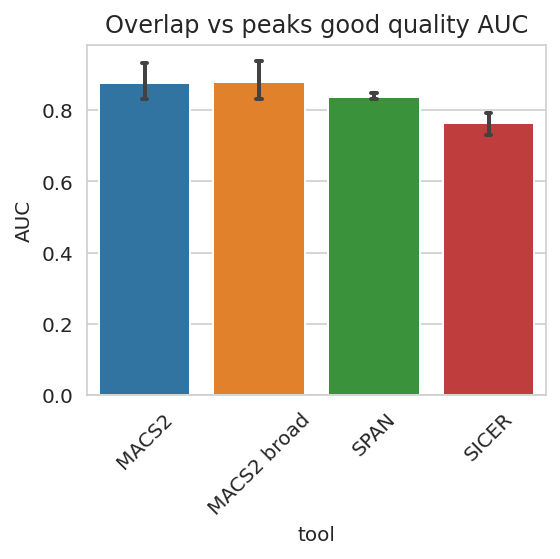

In [26]:
fig = plt.figure(figsize=(4, 4))
g_result = sns.barplot(data=dfapl, x="tool", y="APL", capsize=.05, errwidth=2)
g_result.axes.xaxis.set_tick_params(rotation=45)
# g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Overlap vs peaks good quality AUC')
plt.ylabel('AUC')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K4me3_apl.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Overlap H3K4me3

In [27]:
import tempfile
tf = tempfile.mktemp()

bench_df = pd.DataFrame(
    columns=['cell', 'name', 'peaks', 'peaks_len'],
    dtype=object
)

ts = []
for mln, c in tqdm(product([20, 15, 10, 5, 2, 1], IMMUNE_CELLS)):
    for tool in TOOLS:
        t = df_fdr_peaks[(df_fdr_peaks['quality'] == mln) &
                         (df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        peaks_len = int(bedl(peaks_file).sum())
        ts.append((c, mln, tool, peaks, peaks_len))
        if tool == 'SPAN':
            span_file = sorted_file(t['file'].values[0])
    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['quality'] == mln) &
                         (df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            !bedtools intersect {args} -wa -v > {tf}
            peaks = lines(tf)
            peaks_len = int(bedl(tf).sum())
            ts.append((c, mln, name, peaks, peaks_len))

bench_df = pd.DataFrame(data=ts, columns=['cell', 'quality', 'name', 'peaks', 'length'])
del ts
bench_df.sample(3)

0it [00:00, ?it/s]

,cell,quality,name,peaks,length
36,BCell,15,SPAN - MACS2 broad,657,185111
129,BCell,2,SICER - SPAN,151,381849
96,BCell,5,SPAN - MACS2 broad,578,215370


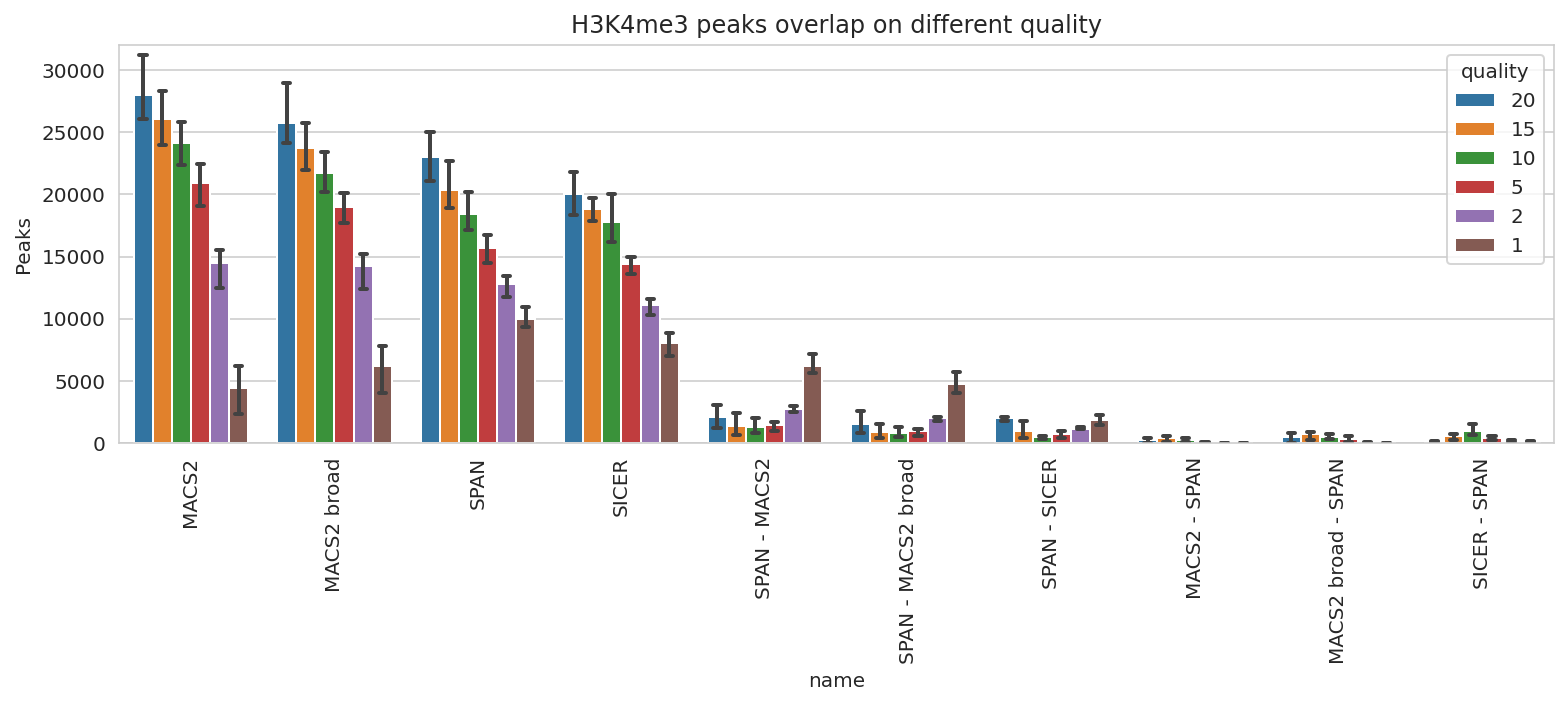

In [28]:
plt.figure(figsize=(11, 5))
ax = plt.axes()
g_results = sns.barplot(data=bench_df, hue='quality',
                        x='name', y='peaks', ax=ax,
                        hue_order=[20, 15, 10, 5, 2, 1],
                        capsize=.05, errwidth=2,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ])
ax.title.set_text('H3K4me3 peaks overlap on different quality')
ax.set_ylabel('Peaks')
ax.set_ylim([0, 32_000])
ax.xaxis.set_tick_params(rotation=90)
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K4me3_overlap.pdf', bbox_inches='tight', dpi=300)
plt.show()

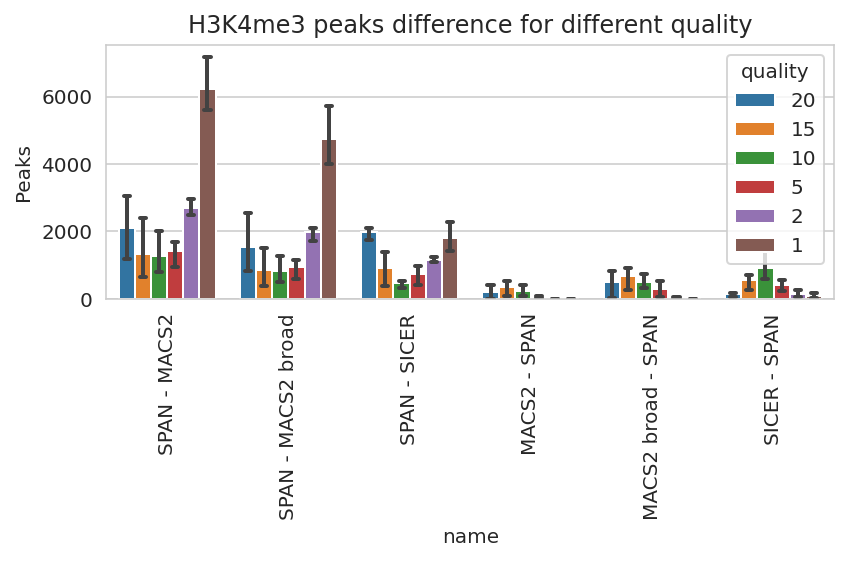

In [29]:
plt.figure(figsize=(6, 4))
ax = plt.axes()
g_results = sns.barplot(data=bench_df, hue='quality',
                        x='name', y='peaks', ax=ax,
                        hue_order=[20, 15, 10, 5, 2, 1],
                        capsize=.05, errwidth=2,
                        order=['SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ])
ax.title.set_text('H3K4me3 peaks difference for different quality')
ax.set_ylabel('Peaks')
# ax.set_ylim([0, 20_000])
ax.xaxis.set_tick_params(rotation=90)
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K4me3_overlap_diff.pdf', bbox_inches='tight', dpi=300)
plt.show()

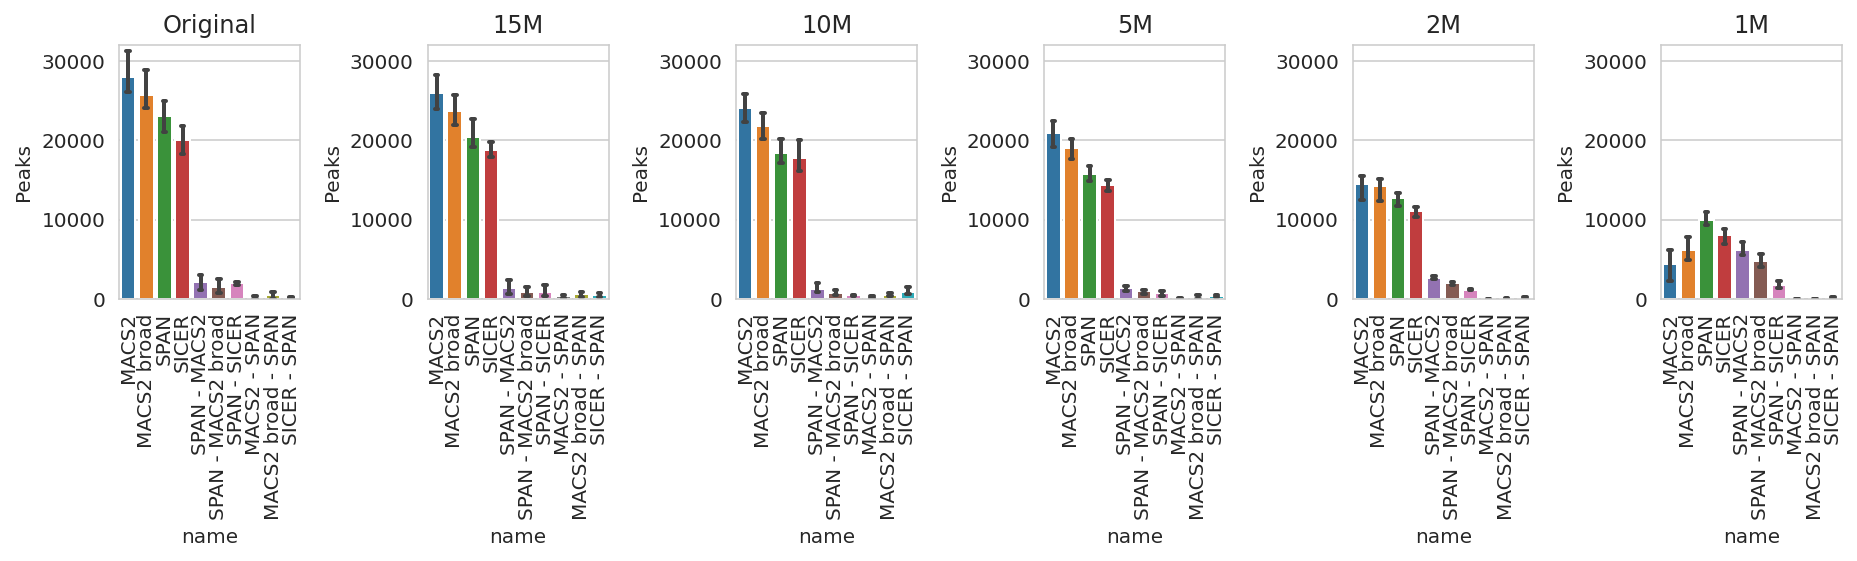

In [30]:
plt.figure(figsize=(13, 4))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]
for i, mln in enumerate([20, 15, 10, 5, 2, 1]):
    ax = axs[i]
    g_results = sns.barplot(data=bench_df[bench_df['quality']==mln],
                            x='name', y='peaks', ax=ax,
                            capsize=.2, errwidth=2,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                   'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                   'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                   ])
    ax.title.set_text(f'{mln}M' if mln != 20 else 'Original')
    ax.set_ylabel('Peaks')
    ax.set_ylim([0, 32_000])
    ax.xaxis.set_tick_params(rotation=90)
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K4me3_overlap_2.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Coverage

In [31]:
# Fraction of reads in peaks
IMMUNE_HG38_PATH_BW = os.path.expanduser('~/data/2023_Immune') + '/bw'


def load_bws(path, m):
    df_bws = pd.DataFrame(columns=['file', 'modification', 'cell'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if '.bw' not in f:
            continue
        cell = next((cc for cc in IMMUNE_CELLS if cc in f), None)
        if cell and m in f:
            df_bws.loc[len(df_bws)] = ((os.path.join(path, f)), m, cell)
    return df_bws

In [32]:
bws_df = load_bws(IMMUNE_HG38_PATH_BW, 'H3K4me3')
display(bws_df.sample(2))
bws_control_df = load_bws(IMMUNE_HG38_PATH_BW, 'Control')
display(bws_control_df.sample(2))

  0%|          | 0/26 [00:00<?, ?it/s]

,file,modification,cell
1,/home/jetbrains/data/2023_Immune/bw/TCell_H3K4...,H3K4me3,TCell
0,/home/jetbrains/data/2023_Immune/bw/BCell_H3K4...,H3K4me3,BCell


  0%|          | 0/26 [00:00<?, ?it/s]

,file,modification,cell
0,/home/jetbrains/data/2023_Immune/bw/TCell_Cont...,Control,TCell
1,/home/jetbrains/data/2023_Immune/bw/Monocyte_C...,Control,Monocyte


In [33]:
CHROM_SIZES = {
    c: s for _, (c, s) in pd.read_csv(os.path.join(PATH, 'hg38.chrom.sizes'),
                                      sep='\t', names=['chr', 'size']).iterrows() if '_' not in c
}
CHROM_SIZES

{'chr1': 248956422,
 'chr2': 242193529,
 'chr3': 198295559,
 'chr4': 190214555,
 'chr5': 181538259,
 'chr6': 170805979,
 'chr7': 159345973,
 'chrX': 156040895,
 'chr8': 145138636,
 'chr9': 138394717,
 'chr11': 135086622,
 'chr10': 133797422,
 'chr12': 133275309,
 'chr13': 114364328,
 'chr14': 107043718,
 'chr15': 101991189,
 'chr16': 90338345,
 'chr17': 83257441,
 'chr18': 80373285,
 'chr20': 64444167,
 'chr19': 58617616,
 'chrY': 57227415,
 'chr22': 50818468,
 'chr21': 46709983,
 'chrM': 16569}

In [34]:
import pyBigWig
import tempfile
from itertools import product

tf = tempfile.mktemp()

coverage_data = []

for mln, c in tqdm(product([20, 15, 10, 5, 2, 1], IMMUNE_CELLS)):
    print(mln, c)
    t = bws_df[(bws_df['modification'] == 'H3K4me3') &
               (bws_df['cell'] == c)]
    if len(t) == 0:
        continue
    bw_file = t['file'].values[0]
    t = bws_control_df[bws_control_df['cell'] == c]
    if len(t) == 0:
        continue
    bw_control_file = t['file'].values[0]

    for tool in TOOLS:
        t = df_fdr_peaks[(df_fdr_peaks['quality'] == mln) &
                         (df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        if lines(peaks_file) > 0:
            t = pd.read_csv(peaks_file, sep='\t', header=None)
            positions = [f'{chr}:{start}-{end}' for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            lengths = [end - start for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            with pyBigWig.open(bw_file) as bw:
                total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
                peaks_coverage = [bw.stats(chr, start, end, type='sum', exact=True)[0]
                                  for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                coverage_data.append(('H3K4me3', mln, c, tool, pos, length, 'treatment', peak_coverage, total_coverage))
            with pyBigWig.open(bw_control_file) as bwc:
                total_coverage = sum(bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
                peaks_coverage = [bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                  for chr, start, end in zip(t[0], t[1], t[2])]
            for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                coverage_data.append(('H3K4me3', mln, c, tool, pos, length, 'control', peak_coverage, total_coverage))
        if tool == 'SPAN':
            span_file = peaks_file

    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['quality'] == mln) &
                         (df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            !bedtools intersect {args} -wa -v > {tf}
            if lines(tf) > 0:
                t = pd.read_csv(tf, sep='\t', header=None)
                positions = [f'{chr}:{start}-{end}' for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                lengths = [end - start for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                with pyBigWig.open(bw_file) as bw:
                    total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
                    peaks_coverage = [bw.stats(chr, start, end, type='sum', exact=True)[0]
                                      for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                    coverage_data.append(('H3K4me3', mln, c, name, pos, length, 'treatment', peak_coverage, total_coverage))
                with pyBigWig.open(bw_control_file) as bwc:
                    total_coverage = sum(bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
                    peaks_coverage = [bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                      for chr, start, end in zip(t[0], t[1], t[2])]
                for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                    coverage_data.append(('H3K4me3', mln, c, name, pos, length, 'control', peak_coverage, total_coverage))

df_coverage = pd.DataFrame(
    coverage_data,
    columns=['modification', 'quality', 'cell', 'name', 'position', 'length', 'type', 'coverage', 'total_coverage']
)
del coverage_data
df_coverage.sample(5)

0it [00:00, ?it/s]

20 BCell
20 TCell
20 Monocyte
15 BCell
15 TCell
15 Monocyte
10 BCell
10 TCell
10 Monocyte
5 BCell
5 TCell
5 Monocyte
2 BCell
2 TCell
2 Monocyte
1 BCell
1 TCell
1 Monocyte


,modification,quality,cell,name,position,length,type,coverage,total_coverage
291255,H3K4me3,20,TCell,MACS2 broad,chr16:81445163-81447203,2040,control,1996.0,2.997870e+09
378167,H3K4me3,20,TCell,SICER,chr7:64569200-64570399,1199,treatment,25991.0,2.440490e+09
1324907,H3K4me3,10,BCell,SICER,chr20:38804200-38808599,4399,control,4000.0,2.476469e+09
594298,H3K4me3,20,Monocyte,SICER,chr2:227414600-227416799,2199,control,2298.0,1.701536e+09
2133540,H3K4me3,5,Monocyte,SPAN - MACS2,chr12:105330309-105330571,262,control,332.0,1.698262e+09


In [35]:
df_coverage['rpm'] = df_coverage['coverage'] / (df_coverage['total_coverage'] / 1e6)
df_coverage['rpkm'] = df_coverage['rpm'] / (df_coverage['length'] / 1e3)

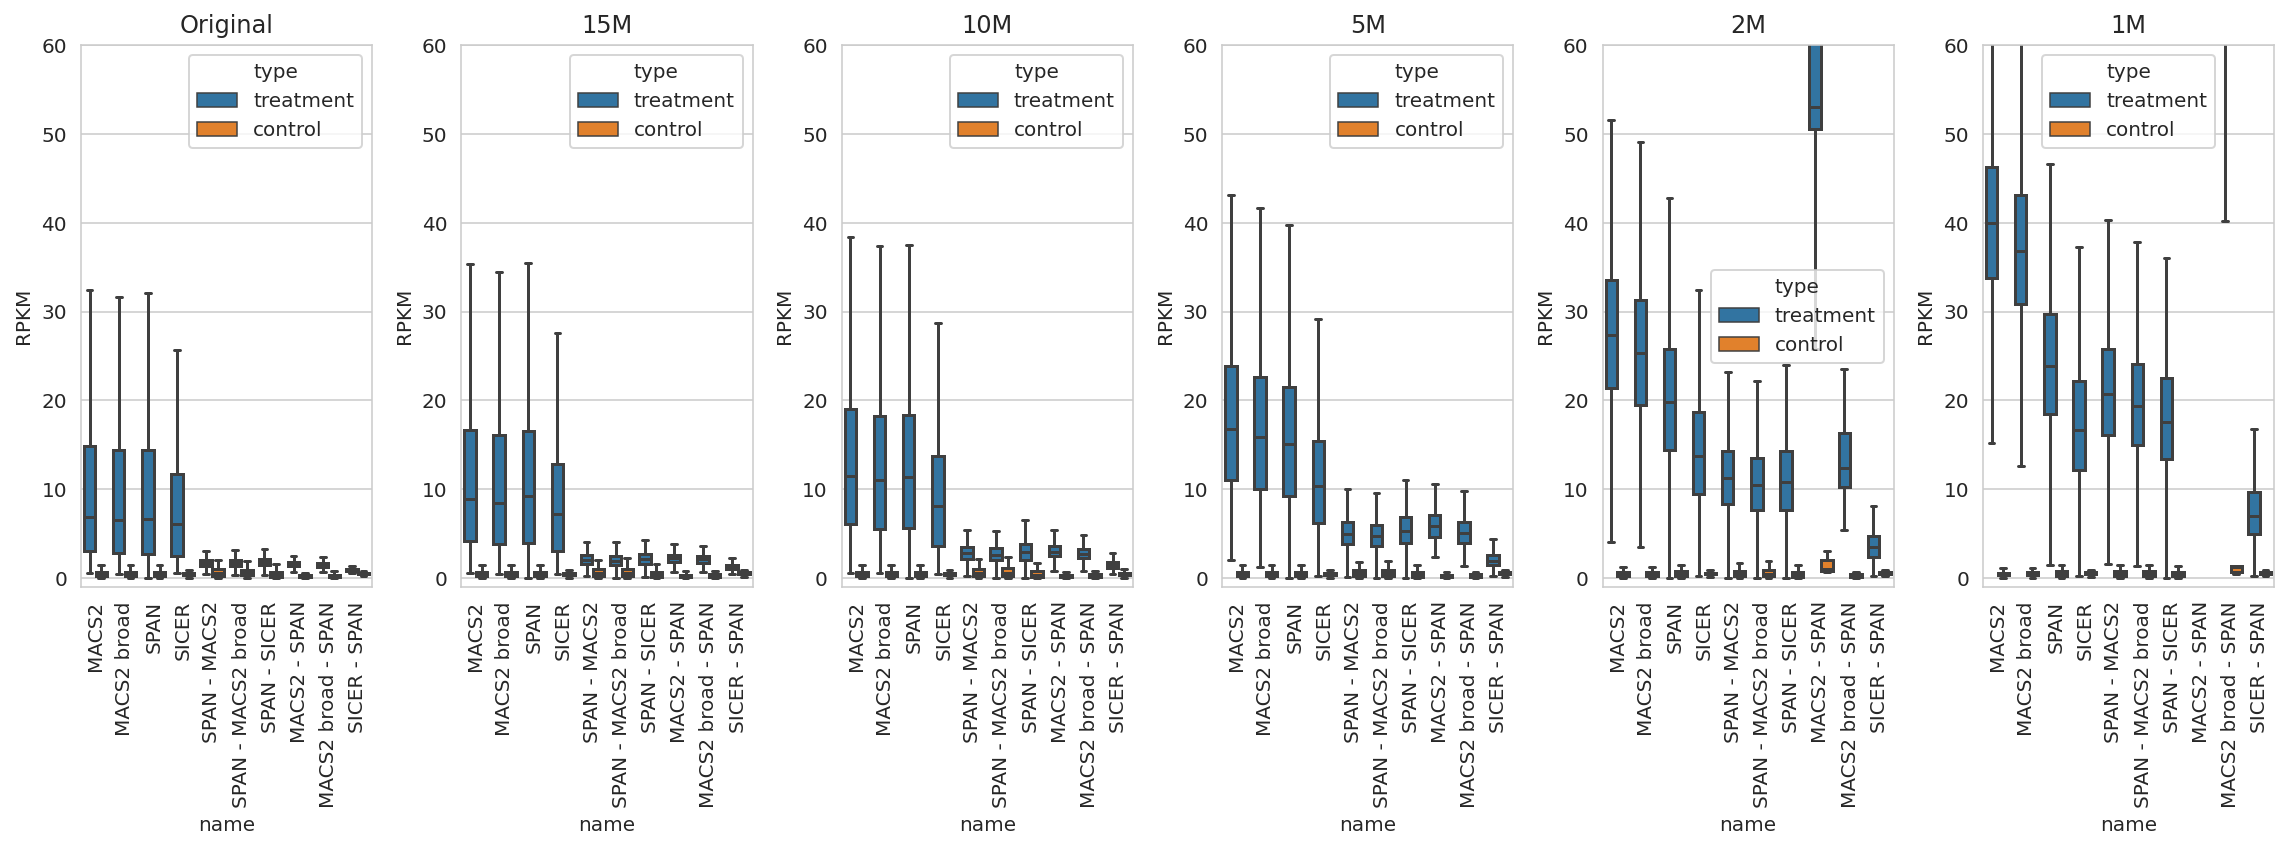

In [36]:
plt.figure(figsize=(16, 6))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]
for i, mln in enumerate([20, 15, 10, 5, 2, 1]):
    ax = axs[i]
    g_results = sns.boxplot(data=df_coverage[df_coverage['quality'] == mln],
                            x='name', y='rpkm', hue='type',
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                   'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                   'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                   ],
                            showfliers=False, ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylabel('RPKM')
    ax.set_ylim(-1, 60)
    ax.title.set_text(f'{mln}M' if mln != 20 else 'Original')

plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K4me3_coverage.pdf', bbox_inches='tight', dpi=300)
plt.show()

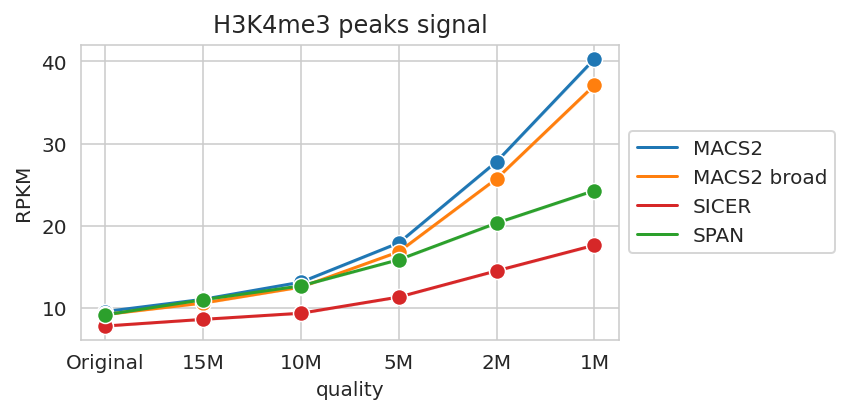

In [37]:
t = df_coverage[(df_coverage['name'].isin(['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])) &
                (df_coverage['type'] == 'treatment')].copy()
t['q'] = 0
for i, mln in enumerate([20, 15, 10, 5, 2, 1]):
    t.loc[t['quality'] == mln, 'q'] = i

plt.figure(figsize=(6, 3))
g_results = sns.lineplot(data=t,
                         x='q', y='rpkm', hue='name',
                         hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                         palette=TOOLS_PALETTE,
                         errorbar='se', marker='o', markersize=8)
g_results.axes.set_xticks(range(6), minor=False)
g_results.axes.set_xticklabels(['Original', '15M', '10M', '5M', '2M', '1M'])
g_results.axes.set_xlabel('quality')
g_results.axes.set_ylabel('RPKM')
g_results.axes.title.set_text(f'H3K4me3 peaks signal')
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K4me3_coverage2.pdf', bbox_inches='tight', dpi=300)
plt.show()

# ChromHMM

In [38]:
CHROMHMM_MAP = {
    'BCell': os.path.expanduser('~/data/2023_Immune') + '/chromhmm/BCell_Chromhmm_hg38_ENCFF885QXH.bed',
    'TCell': os.path.expanduser('~/data/2023_Immune') + '/chromhmm/TCell_Chromhmm_hg38_ENCFF037LJR.bed',
    'Monocyte': os.path.expanduser('~/data/2023_Immune') + '/chromhmm/Monocyte_Chromhmm_hg38_ENCFF560DUU.bed',
}

print('Split chromHMM into separate files')
CHROMM_STATES = set()
for c, chromhmm in CHROMHMM_MAP.items():
    print(c)
    t = pd.read_csv(chromhmm, sep='\t', header=None, usecols=[3])[3]
    for state in t.unique():
        # print(state)
        state = state.replace('/', '_')
        CHROMM_STATES.add(state)
        f = chromhmm.replace('.bed', f'_{state}.bed')
        ! cat {chromhmm} | grep {state} > {f}

CHROMM_STATES = list(sorted(CHROMM_STATES))
print(CHROMM_STATES)

Split chromHMM into separate files
BCell
TCell
Monocyte
['EnhA1', 'EnhA2', 'EnhBiv', 'EnhG1', 'EnhG2', 'EnhWk', 'Het', 'Quies', 'ReprPC', 'ReprPCWk', 'TssA', 'TssBiv', 'TssFlnk', 'TssFlnkD', 'TssFlnkU', 'Tx', 'TxWk', 'ZNF_Rpts']


In [39]:
import tempfile

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

data = []

for mln, c in tqdm(product([20, 15, 10, 5, 2, 1], IMMUNE_CELLS)):
    print(mln, c)
    if c not in CHROMHMM_MAP:
        continue
    chromhmm = CHROMHMM_MAP[c]
    for tool in TOOLS:
        t = df_fdr_peaks[(df_fdr_peaks['quality'] == mln) &
                         (df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        row = [c, mln, tool, peaks]
        for state in CHROMM_STATES:
            state_file = sorted_file(chromhmm.replace('.bed', f'_{state}.bed'))
            !bedtools intersect -a {peaks_file} -b {state_file} -wa -u > {tf}
            state_peaks = lines(tf)
            row.append(state_peaks)
        data.append(row)

        if tool == 'SPAN':
            span_file = peaks_file

    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['quality'] == mln) &
                         (df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            ! bedtools intersect {args} -wa -v > {tf}
            peaks = lines(tf)
            row = [c, mln, name, peaks]
            for state in CHROMM_STATES:
                state_file = sorted_file(chromhmm.replace('.bed', f'_{state}.bed'))
                !bedtools intersect -a {tf} -b {state_file} -wa -u > {tf2}
                state_peaks = lines(tf2)
                row.append(state_peaks)
            data.append(row)

chromhmm_df = pd.DataFrame(data, columns=['cell', 'quality', 'name', 'peaks'] + CHROMM_STATES)
chromhmm_df

0it [00:00, ?it/s]

20 BCell
20 TCell
20 Monocyte
15 BCell
15 TCell
15 Monocyte
10 BCell
10 TCell
10 Monocyte
5 BCell
5 TCell
5 Monocyte
2 BCell
2 TCell
Error: line number 13156 of file /tmp/tmp9k7aqgb7 has 2 fields, but 9 were expected.
Error: line number 2267 of file /tmp/tmpw00bc7kl has 1 fields, but 9 were expected.
2 Monocyte
1 BCell
1 TCell
1 Monocyte


,cell,quality,name,peaks,EnhA1,EnhA2,EnhBiv,EnhG1,EnhG2,EnhWk,...,ReprPC,ReprPCWk,TssA,TssBiv,TssFlnk,TssFlnkD,TssFlnkU,Tx,TxWk,ZNF_Rpts
0,BCell,20,MACS2,26066,5502,489,3029,138,714,6854,...,553,280,9611,4422,20232,10874,14143,299,297,0
1,BCell,20,MACS2 broad,24118,6322,534,3246,193,722,7604,...,610,311,9031,4115,18259,10424,13119,326,324,0
2,BCell,20,SPAN,21067,5438,436,2069,135,647,5431,...,347,187,8666,3591,16220,9898,12146,206,205,0
3,BCell,20,SICER,18342,7236,1071,3356,931,831,12049,...,2584,1605,8557,3209,15010,9441,11585,2545,2423,0
4,BCell,20,SPAN - MACS2,1189,699,27,75,7,43,161,...,19,14,2,30,292,161,119,7,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,Monocyte,1,MACS2 - SPAN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
176,Monocyte,1,SPAN - MACS2 broad,4480,29,14,21,0,36,29,...,4,1,2773,772,3616,353,3427,1,1,0
177,Monocyte,1,MACS2 broad - SPAN,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
178,Monocyte,1,SPAN - SICER,1728,4,4,12,0,11,8,...,3,1,860,348,1241,135,1116,0,0,0


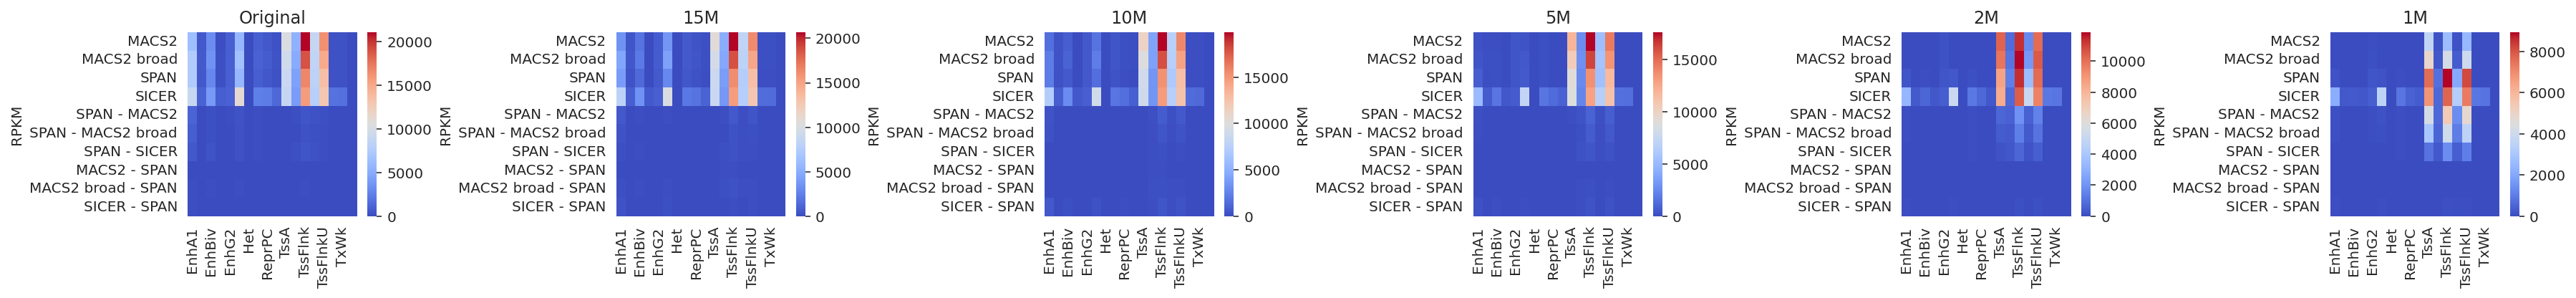

In [40]:
plt.figure(figsize=(25, 3))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]
for i, mln in enumerate([20, 15, 10, 5, 2, 1]):
    chromhmm_qual_df = chromhmm_df[chromhmm_df['quality'] == mln]
    chrommm_df_mean = chromhmm_qual_df[['name'] + CHROMM_STATES].groupby('name').mean()
    chrommm_df_mean = chrommm_df_mean.loc[['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                       'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                       'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                       ]]
    ax = axs[i]
    sns.heatmap(chrommm_df_mean, cmap='coolwarm', ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylabel('RPKM')
    ax.title.set_text(f'{mln}M' if mln != 20 else 'Original')

plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K4me3_chromhmm.pdf', bbox_inches='tight', dpi=300)
plt.show()